# Imports

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score

# Data Exploration

## Reading the data

In [ ]:
test_data = pd.read_csv("music3s_test.csv")
train_data_X = pd.read_csv("music3s_trainin.csv")
train_data_Y = pd.read_csv("music3s_trainlabel.csv")

In [ ]:
test_data.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,66149,0.228706,0.083135,0.154768,0.001907,1732.055688,4.679832e+05,2088.584427,260028.504236,3981.240798,3.477463e+06,0.056520,0.000550,-0.000071,0.021069,-0.000087,0.001575,135.999178,-166.412689,5665.153320,112.661247,1493.085327,17.512598,336.281982,51.973339,316.366577,-8.789105,140.937332,13.669201,165.556732,-20.963209,309.077728,18.787178,153.597015,-22.626720,161.755875,8.636198,234.101837,-8.782756,82.555016,1.926819,59.487900,-6.007792,124.544388,6.750431,37.912651,-11.543827,179.006485,4.398840,41.173435,-21.212402,90.644249,1.496641,214.375336,-5.109190,55.896881,3.900322,130.129562
1,66149,0.492342,0.087816,0.217563,0.002307,3006.499243,1.828219e+05,2470.945703,17839.176934,5983.911508,3.370909e+05,0.133301,0.001954,0.000140,0.024192,0.000067,0.016618,95.703125,-58.095688,1354.395386,46.104359,157.666504,-23.514881,83.729378,80.061768,92.838234,3.474430,66.351746,35.677799,35.654716,-14.049729,49.170654,36.201241,76.919922,-17.509766,42.346237,16.208843,39.994606,-8.379209,36.562531,13.235115,45.882641,-15.599296,29.190155,5.504661,34.516148,-9.707472,28.487309,4.737508,35.835171,-9.876428,20.772022,0.435814,25.417454,-2.759823,31.414402,-4.902189,21.949842
2,66149,0.431939,0.082737,0.162743,0.004080,3469.766145,3.243690e+05,3091.321911,40165.134793,7375.701810,7.381380e+05,0.174309,0.002788,0.000023,0.010903,-0.000024,0.008768,129.199219,-24.497238,2553.337646,54.948536,273.450134,1.383548,126.504585,14.149459,96.763206,10.687451,96.550102,11.946148,43.643688,6.417214,37.197636,6.054286,40.923046,0.252553,24.851948,5.508707,34.265526,6.484787,97.172806,1.969143,25.757444,-5.237513,37.608051,1.067765,28.146561,-2.204784,29.655212,-2.713202,31.147062,0.547347,22.268698,4.719409,43.861397,3.859267,37.126080,4.986750,34.689640
3,66149,0.390378,0.101759,0.100456,0.001691,2615.747972,1.442071e+06,2800.107483,518662.705762,5754.085975,6.849960e+06,0.094321,0.003432,-0.005840,0.007321,-0.002812,0.002261,143.554688,-178.524307,6099.921875,76.522301,1439.829346,6.625253,708.780457,13.388246,296.921234,33.177341,180.573456,22.450533,85.268990,4.651651,67.146317,12.178862,78.653755,10.864746,65.554298,6.999047,99.139931,-0.727164,115.388535,6.670281,64.051262,-1.469985,82.021950,-8.592913,58.756008,0.223761,32.333824,2.573368,45.859516,-1.955187,70.916939,4.484223,102.640442,1.409926,61.008450,3.849368,59.514896
4,66149,0.548817,0.058442,0.119188,0.000529,2510.401100,7.379144e+04,2096.734301,32300.157762,4834.783842,3.572972e+05,0.162402,0.000876,-0.000055,0.005349,-0.000985,0.003475,92.285156,-49.078697,289.769745,99.754318,166.704407,-48.493847,113.899597,54.447701,43.258095,-26.304142,44.848301,25.780863,56.243301,-19.821226,31.187737,21.785692,31.593269,-17.400833,29.761425,15.225873,39.963318,-17.065395,23.932981,9.803946,37.280708,-18.857107,25.777863,1.332950,30.285769,-7.956743,27.199789,2.508395,26.165518,-6.895631,24.110634,6.216244,16.014769,-2.699308,20.399574,3.688766,14.909794


## Dropping a random column called 'Unnamed: 0'. It was just a row numbering column.

In [ ]:
train_data_X.drop('Unnamed: 0', axis = 1, inplace = True)
train_data_X.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,66149,0.294208,0.082441,0.244679,0.004789,1814.911517,8.938208e+04,1942.463756,37699.946360,3723.008000,5.351847e+05,0.083744,0.000260,-0.000009,0.033378,-0.000143,1.432772e-02,86.132812,-42.678871,1881.421753,123.500679,233.423431,-32.434620,153.499542,35.405903,211.086731,-15.101437,163.415451,14.378749,68.442741,-23.411831,127.824715,4.609813,74.555595,-18.231264,67.094765,13.509315,100.293510,-18.610142,53.205288,6.357347,45.468567,-13.265476,54.793373,5.455819,83.132545,-3.323775,92.671844,7.293303,62.239697,-9.708285,60.948383,6.356916,32.187160,-11.304144,43.234917,-3.912638,28.110699
1,66149,0.422152,0.083139,0.207273,0.005126,2415.001764,4.627643e+05,2366.397213,110376.181021,5203.250075,1.715323e+06,0.118070,0.003304,-0.000004,0.019755,0.000343,1.325399e-02,117.453835,-52.534332,2276.794189,93.090172,564.922852,-15.850793,436.355988,42.989265,128.294312,-4.162411,88.794525,23.905220,164.631668,-25.804331,130.728531,25.904886,31.527840,-10.980536,69.332123,13.268557,61.290203,-16.927929,42.668343,10.834379,39.307205,-8.820495,52.296589,6.282006,91.432373,-12.347875,49.488758,0.749722,35.509193,-9.341257,34.133049,2.902299,43.447670,-7.667639,42.453259,4.986269,42.384872
2,66149,0.505224,0.081275,0.201223,0.018823,2947.976142,9.981914e+05,2974.865992,187870.884899,6481.576961,3.669111e+06,0.126750,0.007881,-0.000004,0.025496,-0.000753,1.796796e-02,184.570312,-69.030060,2787.178955,66.499428,635.337402,1.086403,509.636047,14.325823,243.936630,13.896943,226.616104,1.592489,162.020615,0.181935,129.509201,6.253845,128.505966,-1.036986,114.828110,-1.738568,73.309120,4.579821,80.148575,7.432024,106.331100,4.607101,75.371201,3.805624,73.892380,3.528298,58.462673,1.256687,54.585705,-1.163385,44.216702,-1.035314,27.392616,-1.313192,25.259705,-3.237409,42.950947
3,66149,0.551893,0.074110,0.232830,0.007479,3347.736433,1.341207e+06,3160.112695,324465.741697,7117.883113,6.441266e+06,0.153850,0.006395,0.000042,0.029509,-0.000042,1.535663e-02,215.332031,-65.464165,11343.215820,48.116970,1132.310303,23.581091,393.001404,34.186878,94.677628,23.192045,159.503952,17.631529,136.870438,13.698021,60.300407,6.392010,69.436012,7.927260,78.232712,11.647467,78.149925,4.524543,35.619247,-1.925418,51.298912,1.584003,60.531425,2.283320,47.115509,3.678529,46.951138,2.859503,36.897789,-1.076763,52.676277,1.870225,46.482338,0.555163,58.585815,0.131217,24.874531
4,66149,0.189530,0.082946,0.007423,0.000013,1486.228118,8.523230e+04,1668.533965,72816.588865,2972.244591,3.623610e+05,0.075774,0.000539,-0.000012,0.000065,-0.000007,3.589680e-07,151.999081,-481.518677,2309.011475,119.467728,795.415100,-22.858740,194.980179,47.437641,51.056183,-3.821216,23.093790,6.233565,70.470985,-13.633506,65.565567,5.878240,78.961021,-14.227146,37.791355,15.665579,85.018623,4.368495,104.563988,15.128421,82.767746,5.336925,106.876160,9.479575,254.757217,6.558270,361.127411,8.130152,90.453217,6.896601,147.001343,6.240397,204.053833,0.557241,57.508965,3.101098,36.828953


In [ ]:
train_data_X.shape

(8991, 58)

In [ ]:
train_data_Y.drop('Unnamed: 0', axis = 1, inplace = True)
train_data_Y.head()

,label
0,country
1,disco
2,hiphop
3,pop
4,classical


## Checking how many unique values each column has

In [ ]:
for col in train_data_X.columns:
    print(f'{col} -->\t', train_data_X[col].nunique())

length -->	 1
chroma_stft_mean -->	 8872
chroma_stft_var -->	 8864
rms_mean -->	 8874
rms_var -->	 8873
spectral_centroid_mean -->	 8874
spectral_centroid_var -->	 8874
spectral_bandwidth_mean -->	 8874
spectral_bandwidth_var -->	 8874
rolloff_mean -->	 8321
rolloff_var -->	 8874
zero_crossing_rate_mean -->	 8000
zero_crossing_rate_var -->	 8873
harmony_mean -->	 8874
harmony_var -->	 8874
perceptr_mean -->	 8874
perceptr_var -->	 8873
tempo -->	 58
mfcc1_mean -->	 8873
mfcc1_var -->	 8873
mfcc2_mean -->	 8865
mfcc2_var -->	 8873
mfcc3_mean -->	 8874
mfcc3_var -->	 8870
mfcc4_mean -->	 8871
mfcc4_var -->	 8867
mfcc5_mean -->	 8872
mfcc5_var -->	 8872
mfcc6_mean -->	 8871
mfcc6_var -->	 8871
mfcc7_mean -->	 8874
mfcc7_var -->	 8871
mfcc8_mean -->	 8874
mfcc8_var -->	 8874
mfcc9_mean -->	 8873
mfcc9_var -->	 8870
mfcc10_mean -->	 8874
mfcc10_var -->	 8872
mfcc11_mean -->	 8873
mfcc11_var -->	 8874
mfcc12_mean -->	 8874
mfcc12_var -->	 8874
mfcc13_mean -->	 8874
mfcc13_var -->	 8874
mfcc1

Since column 'length' has only 1 unique value, thus we can drop it.

We also notice that 'tempo' has 58 unique values, so maybe it will help as a splitting factor for a decision tree.

In [ ]:
train_data_X.drop('length', axis = 1, inplace = True)
train_data_X.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.294208,0.082441,0.244679,0.004789,1814.911517,8.938208e+04,1942.463756,37699.946360,3723.008000,5.351847e+05,0.083744,0.000260,-0.000009,0.033378,-0.000143,1.432772e-02,86.132812,-42.678871,1881.421753,123.500679,233.423431,-32.434620,153.499542,35.405903,211.086731,-15.101437,163.415451,14.378749,68.442741,-23.411831,127.824715,4.609813,74.555595,-18.231264,67.094765,13.509315,100.293510,-18.610142,53.205288,6.357347,45.468567,-13.265476,54.793373,5.455819,83.132545,-3.323775,92.671844,7.293303,62.239697,-9.708285,60.948383,6.356916,32.187160,-11.304144,43.234917,-3.912638,28.110699
1,0.422152,0.083139,0.207273,0.005126,2415.001764,4.627643e+05,2366.397213,110376.181021,5203.250075,1.715323e+06,0.118070,0.003304,-0.000004,0.019755,0.000343,1.325399e-02,117.453835,-52.534332,2276.794189,93.090172,564.922852,-15.850793,436.355988,42.989265,128.294312,-4.162411,88.794525,23.905220,164.631668,-25.804331,130.728531,25.904886,31.527840,-10.980536,69.332123,13.268557,61.290203,-16.927929,42.668343,10.834379,39.307205,-8.820495,52.296589,6.282006,91.432373,-12.347875,49.488758,0.749722,35.509193,-9.341257,34.133049,2.902299,43.447670,-7.667639,42.453259,4.986269,42.384872
2,0.505224,0.081275,0.201223,0.018823,2947.976142,9.981914e+05,2974.865992,187870.884899,6481.576961,3.669111e+06,0.126750,0.007881,-0.000004,0.025496,-0.000753,1.796796e-02,184.570312,-69.030060,2787.178955,66.499428,635.337402,1.086403,509.636047,14.325823,243.936630,13.896943,226.616104,1.592489,162.020615,0.181935,129.509201,6.253845,128.505966,-1.036986,114.828110,-1.738568,73.309120,4.579821,80.148575,7.432024,106.331100,4.607101,75.371201,3.805624,73.892380,3.528298,58.462673,1.256687,54.585705,-1.163385,44.216702,-1.035314,27.392616,-1.313192,25.259705,-3.237409,42.950947
3,0.551893,0.074110,0.232830,0.007479,3347.736433,1.341207e+06,3160.112695,324465.741697,7117.883113,6.441266e+06,0.153850,0.006395,0.000042,0.029509,-0.000042,1.535663e-02,215.332031,-65.464165,11343.215820,48.116970,1132.310303,23.581091,393.001404,34.186878,94.677628,23.192045,159.503952,17.631529,136.870438,13.698021,60.300407,6.392010,69.436012,7.927260,78.232712,11.647467,78.149925,4.524543,35.619247,-1.925418,51.298912,1.584003,60.531425,2.283320,47.115509,3.678529,46.951138,2.859503,36.897789,-1.076763,52.676277,1.870225,46.482338,0.555163,58.585815,0.131217,24.874531
4,0.189530,0.082946,0.007423,0.000013,1486.228118,8.523230e+04,1668.533965,72816.588865,2972.244591,3.623610e+05,0.075774,0.000539,-0.000012,0.000065,-0.000007,3.589680e-07,151.999081,-481.518677,2309.011475,119.467728,795.415100,-22.858740,194.980179,47.437641,51.056183,-3.821216,23.093790,6.233565,70.470985,-13.633506,65.565567,5.878240,78.961021,-14.227146,37.791355,15.665579,85.018623,4.368495,104.563988,15.128421,82.767746,5.336925,106.876160,9.479575,254.757217,6.558270,361.127411,8.130152,90.453217,6.896601,147.001343,6.240397,204.053833,0.557241,57.508965,3.101098,36.828953


## Let's see how correlated all the columns are

In [ ]:
df = train_data_X.copy()
df.insert(0, 'label', train_data_Y['label'])
df.head()

,label,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,country,0.294208,0.082441,0.244679,0.004789,1814.911517,8.938208e+04,1942.463756,37699.946360,3723.008000,5.351847e+05,0.083744,0.000260,-0.000009,0.033378,-0.000143,1.432772e-02,86.132812,-42.678871,1881.421753,123.500679,233.423431,-32.434620,153.499542,35.405903,211.086731,-15.101437,163.415451,14.378749,68.442741,-23.411831,127.824715,4.609813,74.555595,-18.231264,67.094765,13.509315,100.293510,-18.610142,53.205288,6.357347,45.468567,-13.265476,54.793373,5.455819,83.132545,-3.323775,92.671844,7.293303,62.239697,-9.708285,60.948383,6.356916,32.187160,-11.304144,43.234917,-3.912638,28.110699
1,disco,0.422152,0.083139,0.207273,0.005126,2415.001764,4.627643e+05,2366.397213,110376.181021,5203.250075,1.715323e+06,0.118070,0.003304,-0.000004,0.019755,0.000343,1.325399e-02,117.453835,-52.534332,2276.794189,93.090172,564.922852,-15.850793,436.355988,42.989265,128.294312,-4.162411,88.794525,23.905220,164.631668,-25.804331,130.728531,25.904886,31.527840,-10.980536,69.332123,13.268557,61.290203,-16.927929,42.668343,10.834379,39.307205,-8.820495,52.296589,6.282006,91.432373,-12.347875,49.488758,0.749722,35.509193,-9.341257,34.133049,2.902299,43.447670,-7.667639,42.453259,4.986269,42.384872
2,hiphop,0.505224,0.081275,0.201223,0.018823,2947.976142,9.981914e+05,2974.865992,187870.884899,6481.576961,3.669111e+06,0.126750,0.007881,-0.000004,0.025496,-0.000753,1.796796e-02,184.570312,-69.030060,2787.178955,66.499428,635.337402,1.086403,509.636047,14.325823,243.936630,13.896943,226.616104,1.592489,162.020615,0.181935,129.509201,6.253845,128.505966,-1.036986,114.828110,-1.738568,73.309120,4.579821,80.148575,7.432024,106.331100,4.607101,75.371201,3.805624,73.892380,3.528298,58.462673,1.256687,54.585705,-1.163385,44.216702,-1.035314,27.392616,-1.313192,25.259705,-3.237409,42.950947
3,pop,0.551893,0.074110,0.232830,0.007479,3347.736433,1.341207e+06,3160.112695,324465.741697,7117.883113,6.441266e+06,0.153850,0.006395,0.000042,0.029509,-0.000042,1.535663e-02,215.332031,-65.464165,11343.215820,48.116970,1132.310303,23.581091,393.001404,34.186878,94.677628,23.192045,159.503952,17.631529,136.870438,13.698021,60.300407,6.392010,69.436012,7.927260,78.232712,11.647467,78.149925,4.524543,35.619247,-1.925418,51.298912,1.584003,60.531425,2.283320,47.115509,3.678529,46.951138,2.859503,36.897789,-1.076763,52.676277,1.870225,46.482338,0.555163,58.585815,0.131217,24.874531
4,classical,0.189530,0.082946,0.007423,0.000013,1486.228118,8.523230e+04,1668.533965,72816.588865,2972.244591,3.623610e+05,0.075774,0.000539,-0.000012,0.000065,-0.000007,3.589680e-07,151.999081,-481.518677,2309.011475,119.467728,795.415100,-22.858740,194.980179,47.437641,51.056183,-3.821216,23.093790,6.233565,70.470985,-13.633506,65.565567,5.878240,78.961021,-14.227146,37.791355,15.665579,85.018623,4.368495,104.563988,15.128421,82.767746,5.336925,106.876160,9.479575,254.757217,6.558270,361.127411,8.130152,90.453217,6.896601,147.001343,6.240397,204.053833,0.557241,57.508965,3.101098,36.828953


### Categorical coding the label column
Need to do this because a correlation matrix needs numerical data.

In [ ]:
df['label'] =df['label'].astype('category').cat.codes

In [ ]:
df.head() # country is mapped to 2, disco to 3 and so on

,label,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,2,0.294208,0.082441,0.244679,0.004789,1814.911517,8.938208e+04,1942.463756,37699.946360,3723.008000,5.351847e+05,0.083744,0.000260,-0.000009,0.033378,-0.000143,1.432772e-02,86.132812,-42.678871,1881.421753,123.500679,233.423431,-32.434620,153.499542,35.405903,211.086731,-15.101437,163.415451,14.378749,68.442741,-23.411831,127.824715,4.609813,74.555595,-18.231264,67.094765,13.509315,100.293510,-18.610142,53.205288,6.357347,45.468567,-13.265476,54.793373,5.455819,83.132545,-3.323775,92.671844,7.293303,62.239697,-9.708285,60.948383,6.356916,32.187160,-11.304144,43.234917,-3.912638,28.110699
1,3,0.422152,0.083139,0.207273,0.005126,2415.001764,4.627643e+05,2366.397213,110376.181021,5203.250075,1.715323e+06,0.118070,0.003304,-0.000004,0.019755,0.000343,1.325399e-02,117.453835,-52.534332,2276.794189,93.090172,564.922852,-15.850793,436.355988,42.989265,128.294312,-4.162411,88.794525,23.905220,164.631668,-25.804331,130.728531,25.904886,31.527840,-10.980536,69.332123,13.268557,61.290203,-16.927929,42.668343,10.834379,39.307205,-8.820495,52.296589,6.282006,91.432373,-12.347875,49.488758,0.749722,35.509193,-9.341257,34.133049,2.902299,43.447670,-7.667639,42.453259,4.986269,42.384872
2,4,0.505224,0.081275,0.201223,0.018823,2947.976142,9.981914e+05,2974.865992,187870.884899,6481.576961,3.669111e+06,0.126750,0.007881,-0.000004,0.025496,-0.000753,1.796796e-02,184.570312,-69.030060,2787.178955,66.499428,635.337402,1.086403,509.636047,14.325823,243.936630,13.896943,226.616104,1.592489,162.020615,0.181935,129.509201,6.253845,128.505966,-1.036986,114.828110,-1.738568,73.309120,4.579821,80.148575,7.432024,106.331100,4.607101,75.371201,3.805624,73.892380,3.528298,58.462673,1.256687,54.585705,-1.163385,44.216702,-1.035314,27.392616,-1.313192,25.259705,-3.237409,42.950947
3,7,0.551893,0.074110,0.232830,0.007479,3347.736433,1.341207e+06,3160.112695,324465.741697,7117.883113,6.441266e+06,0.153850,0.006395,0.000042,0.029509,-0.000042,1.535663e-02,215.332031,-65.464165,11343.215820,48.116970,1132.310303,23.581091,393.001404,34.186878,94.677628,23.192045,159.503952,17.631529,136.870438,13.698021,60.300407,6.392010,69.436012,7.927260,78.232712,11.647467,78.149925,4.524543,35.619247,-1.925418,51.298912,1.584003,60.531425,2.283320,47.115509,3.678529,46.951138,2.859503,36.897789,-1.076763,52.676277,1.870225,46.482338,0.555163,58.585815,0.131217,24.874531
4,1,0.189530,0.082946,0.007423,0.000013,1486.228118,8.523230e+04,1668.533965,72816.588865,2972.244591,3.623610e+05,0.075774,0.000539,-0.000012,0.000065,-0.000007,3.589680e-07,151.999081,-481.518677,2309.011475,119.467728,795.415100,-22.858740,194.980179,47.437641,51.056183,-3.821216,23.093790,6.233565,70.470985,-13.633506,65.565567,5.878240,78.961021,-14.227146,37.791355,15.665579,85.018623,4.368495,104.563988,15.128421,82.767746,5.336925,106.876160,9.479575,254.757217,6.558270,361.127411,8.130152,90.453217,6.896601,147.001343,6.240397,204.053833,0.557241,57.508965,3.101098,36.828953


### Printing the corr matrix and filtering out columns

In [ ]:
corr=df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



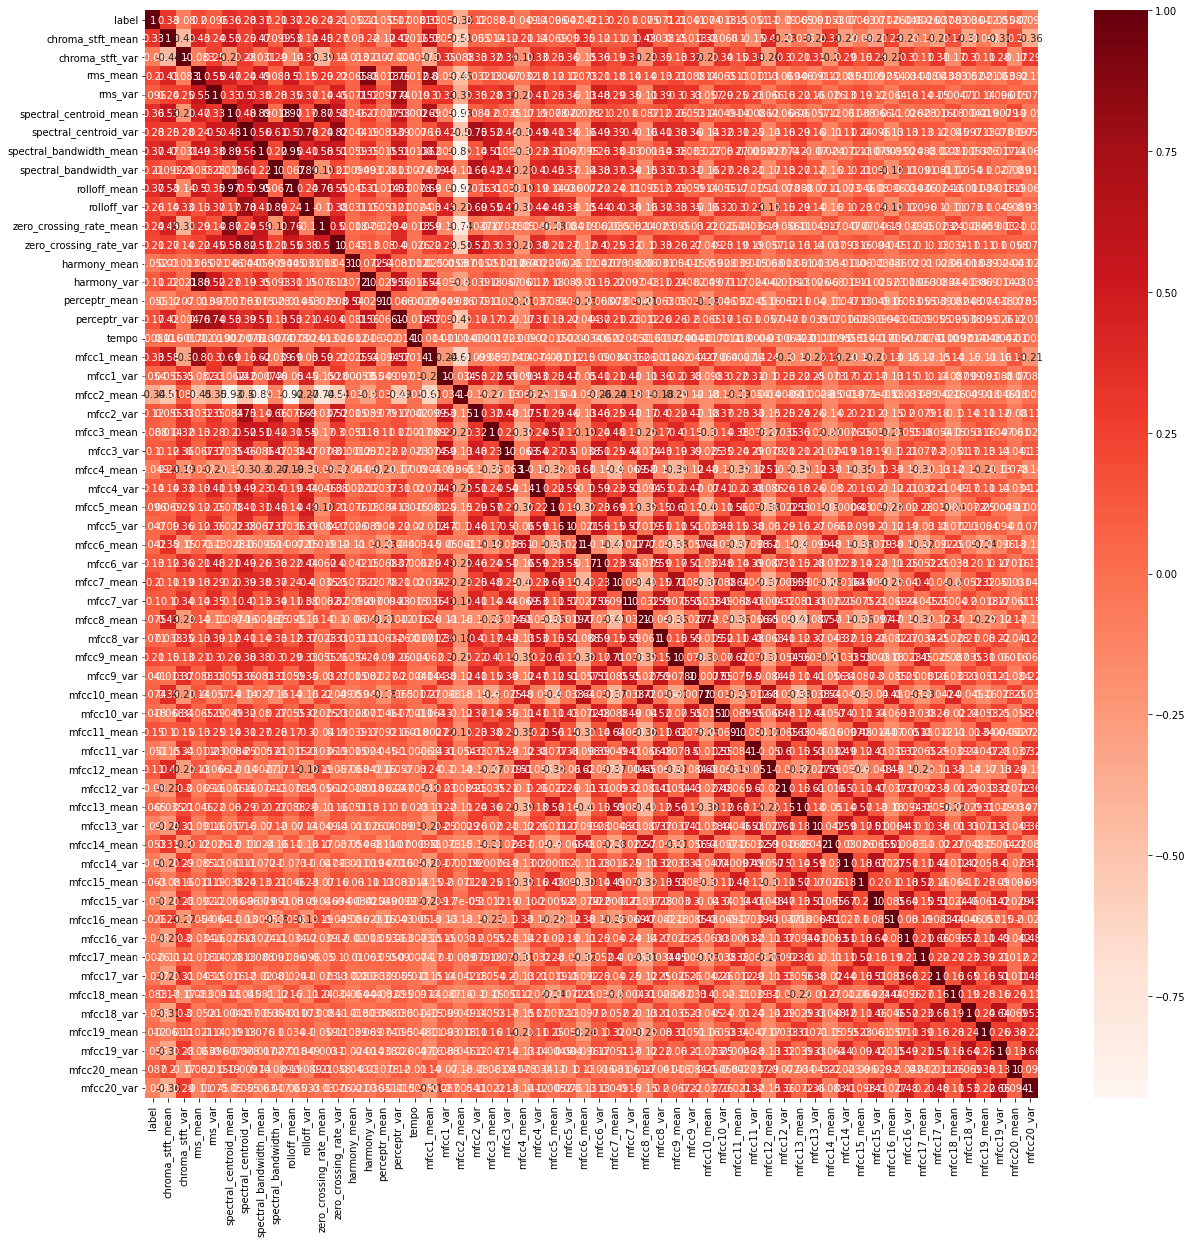

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(20,20))
corr = df.corr()
corr.style.set_precision(2)
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

Hard to read, so let's just get some relatively highly correlated features

In [ ]:
#Correlation with output variable
cor_target = abs(corr["label"])

#Selecting relatively highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

label                      1.000000
chroma_stft_mean           0.328711
spectral_centroid_mean     0.356414
spectral_bandwidth_mean    0.374358
rolloff_mean               0.366898
mfcc1_mean                 0.325635
mfcc2_mean                 0.343991
Name: label, dtype: float64

#### Features relatively highly correlated: 

chroma_stft_mean           
spectral_centroid_mean     
spectral_bandwidth_mean  
rolloff_mean               
mfcc1_mean                 
mfcc2_mean 

In [ ]:
cols = []
for col in relevant_features.keys():
    if col == 'label':
        continue
    cols.append(col)
cols

['chroma_stft_mean',
 'spectral_centroid_mean',
 'spectral_bandwidth_mean',
 'rolloff_mean',
 'mfcc1_mean',
 'mfcc2_mean']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

this method is deprecated in favour of `Styler.format(precision=..)`



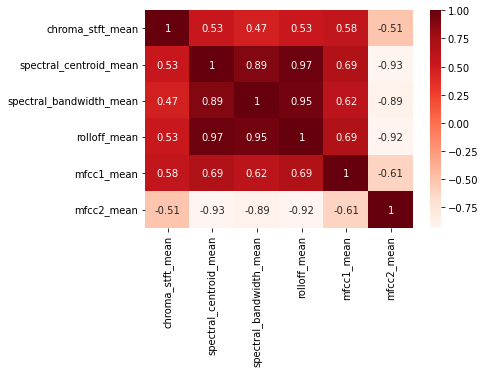

In [ ]:
corr = df[cols].corr()
corr.style.set_precision(2)
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()

roll off mean, chroma stft, and mfcc1 mean are only worth keeping imo

In [ ]:
df = df[['rolloff_mean', 'mfcc1_mean', 'chroma_stft_mean']]

In [ ]:
df.head()

,rolloff_mean,mfcc1_mean,chroma_stft_mean
0,3723.008000,-42.678871,0.294208
1,5203.250075,-52.534332,0.422152
2,6481.576961,-69.030060,0.505224
3,7117.883113,-65.464165,0.551893
4,2972.244591,-481.518677,0.189530


## Predicting using chosen columns

In [ ]:
train_data_Y['label'] = train_data_Y['label'].astype('category').cat.codes

In [ ]:
train_data_Y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data_X, train_data_Y, test_size=0.2, random_state=42)

### Linear Regression Classifier

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train,y_train)

0.28288856755885483

In [ ]:
reg.score(X_test,y_test)

0.27253625016863103

### Decision Tree Classifier

In [ ]:
# Test data

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

yhat_test = clf.predict(X_test)

acc = accuracy_score(y_test, yhat_test)

In [ ]:
acc

0.6264591439688716

In [ ]:
# Train data

yhat_train = clf.predict(X_train)

acc = accuracy_score(y_train, yhat_train)
acc

0.9994438264738599

It is observed that with just using three features, the test accuracy with decision tree classifier is nearly 63%.